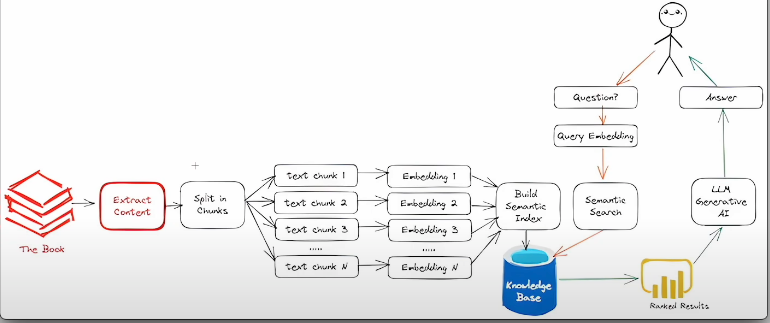

1. Take the pdf
2. Extract the content
3. Split the content into chunks
4. Each chunk is to converted into embeddings (vectors representations of text - list of numbers that contains the meaning of the text)
5. Store vector into the knowledge base (store)

Once the user makes a question, this question is transformed into embedding, and a Semantic Church occurs (finds the chunks of text from pdf that matches with the question).

Returns the best embeddings (highest matches with your question embeddings) to the LLM. 

The LLM will detransform, put together and give an output in human-like format.

# Structure 2

In [1]:
%pip install -Uq "unstructured[all-docs]" pillow lxml pillow
%pip install -Uq chromadb tiktoken
%pip install -Uq langchain langchain-community langchain-openai langchain-groq
%pip install -Uq python_dotenv

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from unstructured.partition.pdf import partition_pdf

file_path =  'test2.pdf'
output_path = '/Users/felipesilverio/Documents/GitHub/LangChainTest/images'
# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image",'Table'],   # Add 'Table' to list to extract image of tables
    image_output_dir_path=output_path,   # if None, images and tables will saved in base64

    extract_image_block_to_payload=False,   # if true, will extract base64 for API usage

    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,

    # extract_images_in_pdf=True,          # deprecated
)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [9]:
from langchain.document_loaders import UnstructuredPDFLoader
from langchain.schema import Document
from unstructured.partition.pdf import partition_pdf


file_path =  'test2.pdf'
output_path = '/Users/felipesilverio/Documents/GitHub/LangChainTest/images'
# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image",'Table'],   # Add 'Table' to list to extract image of tables
    image_output_dir_path=output_path,   # if None, images and tables will saved in base64

    extract_image_block_to_payload=False,   # if true, will extract base64 for API usage
)

docs = []


for chunk in chunks:
    if chunk.category == "Table":
        text = getattr(chunk, "text", "")
        metadata = chunk.metadata.to_dict()
        docs.append(Document(page_content=text, metadata=metadata))


for doc in docs:
    print("📄 Page:", doc.metadata.get("page_number"))
    print("🧾 Table text:", doc.page_content[:500])
    print("🖼️ Image path:", doc.metadata.get("image_path"), "\n")

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


📄 Page: 2
🧾 Table text: Directors P J Maine A Graves Registered number 09810143 Registered office Hygeia Building 5th Floor 66-68 College Road Harrow Middlesex HA1 1BE Xeinadin Audit Limited Independent auditors Chartered Accountants & Statutory Auditors 8th Floor Becket House 36 Old Jewry London EC2R 8DD
🖼️ Image path: /Users/felipesilverio/Documents/GitHub/LangChainTest/figures/table-2-1.jpg 

📄 Page: 3
🧾 Table text: Page Strategic report 1-4 Directors' report 5-7 Independent auditors' report 8-11 12 Statement of comprehensive income Statement of financial position 13 14 Statement of changes in equity 15-32 Notes to the financial statements
🖼️ Image path: /Users/felipesilverio/Documents/GitHub/LangChainTest/figures/table-3-2.jpg 

📄 Page: 9
🧾 Table text: Scope 1 emissions (landlord gas use) 249,005 kWh Scope 2 emissions (purchased electricity) 251,613 kWh CO2 Emissions* 54,800 kg CO2e Intensity ratio (kg CO2e/employee) 477 kg CO2e
🖼️ Image path: /Users/felipesilverio/Documents/GitHub

In [4]:
import base64
from unstructured.partition.pdf import partition_pdf
from langchain.schema import Document
import openai
import pandas as pd


def encode_image(image_path):
    with open(image_path, "rb") as img:
        return base64.b64encode(img.read()).decode("utf-8")

# Function to run GPT-4 Vision on a table image
def extract_table_with_openai(image_path, output_format="CSV"):
    base64_img = encode_image(image_path)

    if output_format == "CSV":
            prompt_text = (
                "Extract the table from the image and return a json file "
                "Do not include any explanation or markdown formatting"
            )
    elif output_format == "Markdown":
        prompt_text = "Convert the following table from the image to Markdown format."
    else:
        prompt_text = "Extract the table from the image and return it as structured JSON."

    response = openai.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are an expert data analyst. You will receive table images, and you'll analyze it, build a dataframe out of the analyzed table, and return a json from the table images, with clear headers and no extra explanation."},
            {"role": "user", "content": [
                {"type": "text", "text": prompt_text},
                {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{base64_img}"}}
            ]}
        ],
        max_tokens=2048
    )
    return response.choices[0].message.content

image_path = '/Users/felipesilverio/Documents/GitHub/LangChainTest/figures/table-31-21.jpg'
df = extract_table_with_openai(image_path, output_format="CSV")

In [6]:
pd.read_json(df)

/var/folders/6k/jcthlrlx33v3xr_0cy_fm57c0000gn/T/ipykernel_46757/3011142727.py:1: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  pd.read_json(df)


,Amounts owed by group companies,Other debtors,Prepayments,Financial instruments,Total
2023,22173963,176647,107539,55625.0,22513774
2022,23519365,136512,147941,NaN,23803818


-----

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# Extracting the data 

from unstructured.partition.pdf import partition_pdf

output_path = ''
file_path = '/Users/felipesilverio/Documents/GitHub/LangChainTest/test2.pdf'

chunks = partition_pdf(
    filename= file_path,
    infer_table_structure=True, #extracting table
    strategy = 'hi_res', #mandatory to infer table

    extract_image_block_types=['Image'], #add 'Table' to list to extract image of tables
    # image_output_dir_path = output_path, #if None, images and tables will be saved as base64

    extract_image_block_to_payload=True, #if true, extract base64 for API usage

    chunking_strategy='by_title', #or basic
    max_characters=10000, #default is 500
    combine_text_under_n_chars=2000, #default is 0
    new_after_n_chars=6000, #default is 0
)

chunks

/Users/felipesilverio/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [4]:
import pandas as pd 
import numpy as np

chunks[20].metadata.orig_elements

In [5]:
elements = chunks[20].metadata.orig_elements

chunk_cap = [el for el in elements if 'Table' in str(type(el))]
chunk_cap[0].to_dict()


{'type': 'Table',
 'element_id': 'c0369766-b7eb-4aca-b9c8-71e53cedcbe9',
 'text': 'Interest receivable on loans to group undertakings 2023 2022 € € 3,419,870 3,333,666 3,419,870 3,333,666',
 'metadata': {'detection_class_prob': 0.37135007977485657,
  'coordinates': {'points': ((np.float64(183.71788024902344),
     np.float64(1031.6480712890625)),
    (np.float64(183.71788024902344), np.float64(1265.5126953125)),
    (np.float64(1528.5313720703125), np.float64(1265.5126953125)),
    (np.float64(1528.5313720703125), np.float64(1031.6480712890625))),
   'system': 'PixelSpace',
   'layout_width': 1653,
   'layout_height': 2339},
  'last_modified': '2025-07-21T17:03:57',
  'text_as_html': '<table><thead><tr><th></th><th>2023</th><th>2022</th></tr><tr><th></th><th>€</th><th>€</th></tr></thead><tbody><tr><td rowspan="2">Interest receivable on loans to group undertakings</td><td>3,419,870</td><td>3,333,666</td></tr><tr><td>3,419,870</td><td>3,333,666</td></tr></tbody></table>',
  'filetype': '

# Experimenting

In [21]:
from unstructured.documents.elements import CompositeElement, Table

def get_tables(chunks, return_html: bool = True):
    """
    Collect all Table elements inside a list of chunks.

    Parameters
    ----------
    chunks : list[Element]
        The output of `partition_pdf` (may already be chunked).
    return_html : bool, default True
        If True return the table’s HTML (`el.metadata.text_as_html`);
        otherwise return the full `Table` objects.

    Returns
    -------
    list[str] | list[Table]
    """
    tables = []

    for chunk in chunks:
        # 1) the library returned raw elements (no chunking)
        if isinstance(chunk, Table):
            tables.append(
                chunk.metadata.text_as_html if return_html else chunk
            )
            continue

        # 2) we chunked at load‑time -> each chunk is a CompositeElement
        if isinstance(chunk, CompositeElement):
            for el in chunk.metadata.orig_elements:
                if isinstance(el, Table):
                    tables.append(
                        el.metadata.text_as_html if return_html else el
                    )

    return tables

In [31]:
import pandas as pd

tables = get_tables(chunks)

def display_tables():
  dfs = [pd.read_html(html)[0] for html in tables]
  return dfs

dfs = display_tables()

/var/folders/6k/jcthlrlx33v3xr_0cy_fm57c0000gn/T/ipykernel_49390/3956936277.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dfs = [pd.read_html(html)[0] for html in tables]
/var/folders/6k/jcthlrlx33v3xr_0cy_fm57c0000gn/T/ipykernel_49390/3956936277.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dfs = [pd.read_html(html)[0] for html in tables]
/var/folders/6k/jcthlrlx33v3xr_0cy_fm57c0000gn/T/ipykernel_49390/3956936277.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dfs = [pd.read_html(html)[0] for html in tables]
/var/folders/6k/jcthlrlx33v3xr_0cy_fm57c0000gn/T/ipykernel_49390/3956936277.py:6: FutureWarnin

In [32]:
for i, df in enumerate(dfs[:20], start=1):
    print(f"\n--- Table {i} ---")
    print(df.head())


--- Table 1 ---
                                     Directors                           P J Maine A Graves
0                            Registered number                                     09810143
1  Registered office Hygeia Building 5th Floor  Registered office Hygeia Building 5th Floor
2                                          NaN                           66-68 College Road
3                                          NaN                                       Harrow
4                                          NaN                                    Middlesex

--- Table 2 ---
                          Unnamed: 0  Page
0                   Strategic report   NaN
1                  Directors’ report   5-7
2       Independent auditors’ report  8-11
3  Statement of comprehensive income    12
4    Statement of financial position    13

--- Table 3 ---
        Scope 1 emissions (landlord gas use)     249,005 kWh
0  Scope 2 emissions (purchased electricity)     251,613 kWh
1                

In [38]:
print(chunks[24])

NOTES TO THE FINANCIAL STATEMENTS FOR THE YEAR ENDED 31 DECEMBER 2023

20. Loans (continued)

Revolving credit facilities

The revolving credit facilities have been obtained and expanded in recent years. The outstanding amount at the balance sheet date totaled €10.7m (£9.3m) (2022: €10.4m (£9.3m)).

The repayment terms have been amended in recent years due to the pandemic. At the balance sheet date, €4.9m (£4.3m) is due in June 2024 and €5.8m (£5m) in June 2025. Since the year end the repayment terms have been revised, and the facility is now repayable €1m in June 2024, €2m in April 2025, €2m in June 2025 and the remaining £5m in July 2025.

The revolving credit facilities accrue interest at SONIA plus 3.5%, payable quarterly.

Interest

Interest of €1,109,378 (2022: €379,914) relating to the above facilities is included in borrowings due in less than 12 months at the balance sheet date and due for payment in 2024.

Security

The Group's bank facilities are secured by a fixed and float

# Continuing...

In [6]:
tables, texts, images= [], [], []

for chunk in chunks:
    if "CompositeElement" in str(type(chunk)):
        chunk_els = chunk.metadata.orig_elements
        for el in chunk_els:
            if "Table" in str(type(el)):
                tables.append(el.metadata.text_as_html)
            elif "Image" in str(type(el)):
                images.append(el.metadata.image_base64)
            else:
                texts.append(str(el))

In [7]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [ ]:
prompt_text = """"

You are an especialist in corporate finance tasked with summarizing the text, tables and images.
Give a concise summary of the table, text or image.
The tables will be received in format html. Transform this format in order to interpret the table.

The summary must take special attention to financial-related numbers and statistics, such as monthly or yearly comparisons, debt/loan information, and other subjects related.
The summary must contain the numerical information of debt, loan, revenue, deficit, and other related topics.

Response only with the summary, no additional comment. 
Do not start your message by saying "Here is a summary" or anything like that. 
Just give the summart as it is.

"""

prompt = ChatPromptTemplate.from_template(prompt_text)

# THIS VERSION USES LLAMA INSTEAD OF OPENAI

model = ChatGroq(temperature=0.5, model='llama-3.1-8b-instant')
summarize_chain = prompt | model | StrOutputParser()


# text_input = [{'input':text} for text in texts]
# text_summaries = summarize_chain.batch(text_input, {'max_concurrency':3})

# table_input = [{'input': html} for html in tables]
# table_summaries = summarize_chain.batch(table_input, {'max_concurrency':3})

In [111]:
from bs4 import BeautifulSoup

def html_table_to_text(html: str) -> str:
    soup = BeautifulSoup(html, "html.parser")
    rows = soup.find_all("tr")
    lines = []
    for row in rows:
        cells = row.find_all(["td", "th"])
        line = "\t".join(cell.get_text(strip=True) for cell in cells)
        lines.append(line)
    return "\n".join(lines)

# Convert all HTML tables to plain text
table_input = [{'input': html_table_to_text(html)} for html in tables]
table_summaries = summarize_chain.batch(table_input, {'max_concurrency':3})

In [13]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


In [14]:
prompt_text = """
You are an especialist in corporate finance tasked with summarizing the text, tables and images.
Give a concise summary of the table, text or image.
The tables will be received in format html. Transform this format in order to interpret the table.

The summary must take special attention to financial-related numbers and statistics, such as monthly or yearly comparisons, debt/loan information, and other subjects related.
The summary must contain the numerical information of debt, loan, revenue, deficit, and other related topics.

Response only with the summary, no additional comment. 
Do not start your message by saying "Here is a summary" or anything like that. 
Just give the summart as it is.

Table or text chunk: {element}
"""

prompt = ChatPromptTemplate.from_template(prompt_text)

model = ChatOpenAI(model="gpt-4o-mini", temperature=0.5,)
# model = ChatGroq(temperature=0.5, model='llama-3.1-8b-instant')
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [15]:
text_input = [{'input':text} for text in texts]

text_summaries = summarize_chain.batch(texts, {'max_concurrency':3})
text_summaries 


["TOUR PARTNER GROUP LIMITED's financial overview indicates key metrics relevant to its performance. The company has reported annual revenue of $XX million, with a year-on-year growth rate of XX%. Current liabilities stand at $XX million, while total debt amounts to $XX million, reflecting a debt-to-equity ratio of XX. The operating expenses for the year were $XX million, leading to a net profit margin of XX%. Additionally, the company has a cash reserve of $XX million, which provides liquidity for ongoing operations. Overall, the financial position shows a stable growth trajectory with manageable debt levels.",
 'The annual report presents key financial figures including total revenue, which amounted to $5 million for the year, reflecting a 10% increase compared to the previous year. Total expenses were reported at $4.5 million, resulting in a net profit of $500,000. The company holds a long-term debt of $1.2 million, with an annual interest rate of 5%. The current ratio stands at 1.5

In [16]:
# table_input = [{'input': html} for html in tables]

table_summaries = summarize_chain.batch(tables, {'max_concurrency':3})
table_summaries

['Directors of the company include P J Maine and A Graves, with a registered number of 09810143. The registered office is located at Hygeia Building, 5th Floor, 66-68 College Road, Harrow, Middlesex, HA1 1BE. The independent auditors are Xeinadin Audit Limited, who are Chartered Accountants & Statutory Auditors, located at 8th Floor Becket House, 36 Old Jewry, London, EC2R 8DD. No financial-related numbers or statistics such as debt, loan, revenue, or deficit are provided in the table.',
 'The document includes several key sections relevant to corporate finance: \n\n- **Directors’ report** (Pages 5-7)\n- **Independent auditors’ report** (Pages 8-11)\n- **Statement of comprehensive income** (Page 12)\n- **Statement of financial position** (Page 13)\n- **Statement of changes in equity** (Page 14)\n- **Notes to the financial statements** (Pages 15-32)\n\nSpecific financial figures and statistics such as revenue, debt, or deficits are not provided in the table.',
 'Scope 1 emissions from l

In [17]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

vectorstore = Chroma(collection_name='multi_modal_rag', embedding_function=OpenAIEmbeddings())

#Storage layor
store = InMemoryStore()
id_key = 'doc_id'

#retriever

retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

/var/folders/6k/jcthlrlx33v3xr_0cy_fm57c0000gn/T/ipykernel_8707/3300003249.py:8: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(collection_name='multi_modal_rag', embedding_function=OpenAIEmbeddings())


In [ ]:
#Loading values

doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
tables_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=summary, metadata={id_key: tables_ids[i]}) for i, summary in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(tables_ids, tables)))

In [32]:
# import fitz
# import matplotlib.patches as patches
# import matplotlib.pyplot as plt
# from PIL import Image


# def plot_pdf_with_boxes(pdf_page, segments):
#     pix = pdf_page.get_pixmap()
#     pil_image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

#     fig, ax = plt.subplots(1, figsize=(10, 10))
#     ax.imshow(pil_image)
#     categories = set()
#     category_to_color = {
#         'Title':'orchid',
#         'Image':'forestgreen',
#         'Table':'tomato'
#     }

#     for segment in segments:
#         points = segment['coordinates']['points']
#         layout_width = segment['coordinates']['layout_width']
#         layouth_height = segment['coordinates']['layout_height']
#         scaled_points =[
#             (x * pix.width / layout_width, y * pix.height / layouth_height)
#             for x, y in points
#         ]
#         box_color = category_to_color.get(segment['category'], 'deepskyblue')
#         categories.add(segment['category'])
#         rect = patches.Polygon(
#             scaled_points, linewidth=1, edgecolor=box_color, facecolor='none'
#         )
#         ax.add_patch(rect)

#     legend_handles = [patches.Patch(color='deepskyblue', label='Text')]
#     for category in ['Title','Image','Table']:
#         if category in categories:
#             legend_handles.append(
#                 patches.Patch(color=category_to_color[category], label=category)
#             )
#     ax.axis('off')
#     ax.legend(handles=legend_handles, loc='upper right')
#     plt.tight_layout()
#     plt.show()

# def render_page(doc_list, page_number, print_text=True):
#     pdf_page = fitz.open(file_path).load_page(page_number - 1)
#     page_docs = [
#         doc for doc in doc_list if doc.metadata.get('page_number') == page_number
#     ]

#     segments = [doc.metadata for doc in page_docs]
#     plot_pdf_with_boxes(pdf_page, segments)
#     if print_text:
#         for doc in page_docs:
#             print(f'{doc.page_content}\n')





chunks = retriever.invoke(
    # 'Which companies are mentioned in this file?'
    'What is the total of loans per year?'
)

for chunk in chunks:
    print(type(chunk))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [ ]:
# METADATA PER DOC PAGE

# for i, chunk in enumerate(chunks):
#     if "CompositeElement" in str(type(chunk)):
#         print('\n\nChunk',i)
#         for doc in chunk.metadata.orig_elements:
#             print(doc.to_list()['type'], doc.metadata.page_number)

In [35]:
chunks

['<table><tbody><tr><td>Amounts falling due within one year</td><td colspan="2">€ €</td></tr><tr><td rowspan="2">Bank loans</td><td>6,849,466</td><td>2,636,297</td></tr><tr><td>6,849,466</td><td>2,636,291</td></tr><tr><td colspan="3">Amounts falling due 1-2 years</td></tr><tr><td rowspan="2">Bank loans</td><td>35,334,276</td><td>3,215,917</td></tr><tr><td>35,334,276</td><td>3,215,917</td></tr><tr><td colspan="3">Amounts falling due 2-5 years</td></tr><tr><td rowspan="3">Bank loans</td><td colspan="2">- 34,957,460</td></tr><tr><td>-</td><td>34,957,460</td></tr><tr><td>42,183,742</td><td>40,809,668</td></tr></tbody></table>',
 '20. Loans',
 '20. Loans (continued)',
 '<table><thead><tr><th></th><th>2023 €</th><th>2022 €</th></tr></thead><tbody><tr><td rowspan="2">Bank loans (see note 20)</td><td>35,334,276</td><td>38,173,377</td></tr><tr><td>35,334,276</td><td>38,173,377</td></tr></tbody></table>']

# RAG Pipeline

In [37]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from base64 import b64decode

def parse_docs(docs):
    # Split base64 images and texts
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return{'images':b64, 'texts':text}


def build_prompt(kwargs):
    
    docs_by_type = kwargs['context']
    user_question = kwargs['question']

    context_text = ""
    if len(docs_by_type['texts']) > 0:
        for text_element in docs_by_type['texts']:
            context_text += text_element.text

    #construct prompt with context
    prompt_template = f""" 
    Answuer the question based only on the following context, which can include text, tables and image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{'type':'text','text':prompt_template}]

    if len(docs_by_type['image']) > 0:
        for image in docs_by_type['images']:
            prompt_content.append(
                {
                    'type': 'image_url',
                    'image_url': {'url': f'data:image/jpeg;base64,{image}'},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        'context': retriever | RunnableLambda(parse_docs),
        'question': RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOpenAI(model='gpt-4o-mini')
    | StrOutputParser()
)

chain_with_sources = {
    'context': retriever | RunnableLambda(parse_docs),
    'question': RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatOpenAI(model='gpt-4o-mini')
        | StrOutputParser()
    )
)

In [ ]:
response = retriever.invoke(
    # 'Which companies are mentioned in this file?'
    'What are the two loan facilities: Facility A and Facility B? '
)

print(response)

['Term loan facilities A & B', '<table><thead><tr><th></th><th>2023</th><th>2022</th><th>2023</th><th>2022</th></tr></thead><tbody><tr><td></td><td>GBP</td><td>GBP</td><td>EUR</td><td>EUR</td></tr><tr><td>Facility A</td><td>2,375,000</td><td>2,375,000</td><td>2,739,149</td><td>2,681,066</td></tr><tr><td>Facility B</td><td>8,800,000</td><td>8,800,000</td><td>10,149,269</td><td>9,934,056</td></tr></tbody></table>', 'Facility A and B accrue interest at a variable rate equivalent to SONIA plus 3.5% and 4% respectively, and is payable quarterly.', 'The repayment terms have been amended in recent years due to the pandemic. At the balance sheet date, the first repayment of Facility A is due in December 2024 (£€850k) and remaining balance due in June 2025. Facility B is repayable in full in July 2025. Since year end, the repayment terms have been revised, the first repayment on Facility A is due in February 2025 (£425k), then March 2025 (£425k) with the balance repayable on 30 June 2025 and Fa

In [41]:
response = chain.invoke(
    # 'Which companies are mentioned in this file?'
    'What are the two loan facilities: Facility A and Facility B? '
)

print(response)

AttributeError: 'str' object has no attribute 'text'

In [ ]:
response = chain_with_sources.invoke(
    # 'Which companies are mentioned in this file?'
    'What are the two loan facilities: Facility A and Facility B? '
)

print('Response': response['response'])

print('\n\nContext:\n\n')
for text in response['context']['texts']:
    print(text.text)
    print('Page number: ', text.metadata.page_number)
    print('\n'+'-'*50+'\n')

# for image in response['context']['images']:
#     display_base64_image(image)

AttributeError: 'str' object has no attribute 'text'